# 数据处理与增强
> M&M数据集提供了来自4个供应商的数据，其中供应商AB的数据用于训练，而ABCD的数据用于测试。'--domain' 参数用于控制训练时使用哪个供应商的数据。'--domain A' 表示仅使用供应商A的数据进行训练。'--domain B' 表示仅使用供应商B的数据进行训练。'--domain AB' 表示同时使用供应商A和B的数据进行训练。在测试阶段，将使用所有4个供应商的数据进行测试。

In [6]:
import SimpleITK as sitk
import numpy as np
import torch.nn.functional as F

lab=sitk.ReadImage("A0S9V9_sa_gt_1.nii.gz")
img=sitk.ReadImage("A0S9V9_sa_1.nii.gz")
spacing=np.array(lab.GetSpacing()).tolist()
print(spacing)
print(spacing[::-1])
print(img.GetSize())


[1.2000000476837158, 1.2000000476837158, 9.520000457763672]
[9.520000457763672, 1.2000000476837158, 1.2000000476837158]
(239, 283, 13)


> - np.clip 是 NumPy 库中的一个函数，用于将数组中的元素限制在指定范围内。它可以将数组中的元素值限制在最小值和最大值之间，超出这个范围的元素会被截断
> - np.percentile 是 NumPy 库中的一个函数，用于计算给定数据集的百分位数（percentile）值。
> - np.pad 是 NumPy 库中的一个函数，用于在数组的边缘填充指定数量的值。

In [7]:
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
p25 = np.percentile(data, 25)  # 计算第25百分位数
p75 = np.percentile(data, 75)  # 计算第75百分位数
print("25th percentile:", p25)
print("75th percentile:", p75)

data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
clipped_data = np.clip(data, 3, 7)  # 将数据限制在范围 [3, 7] 内
print("Original data:", data)
print("Clipped data:", clipped_data)

# 创建一个3x3的数组
arr = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

# 在数组的边缘填充1个元素，使用常数填充
padded_arr = np.pad(arr, pad_width=1, mode='constant', constant_values=0)

print(padded_arr)

25th percentile: 3.25
75th percentile: 7.75
Original data: [ 1  2  3  4  5  6  7  8  9 10]
Clipped data: [3 3 3 4 5 6 7 7 7 7]
[[0 0 0 0 0]
 [0 1 2 3 0]
 [0 4 5 6 0]
 [0 7 8 9 0]
 [0 0 0 0 0]]


# 数据预处理

(13, 283, 239)
torch.Size([13, 283, 265])


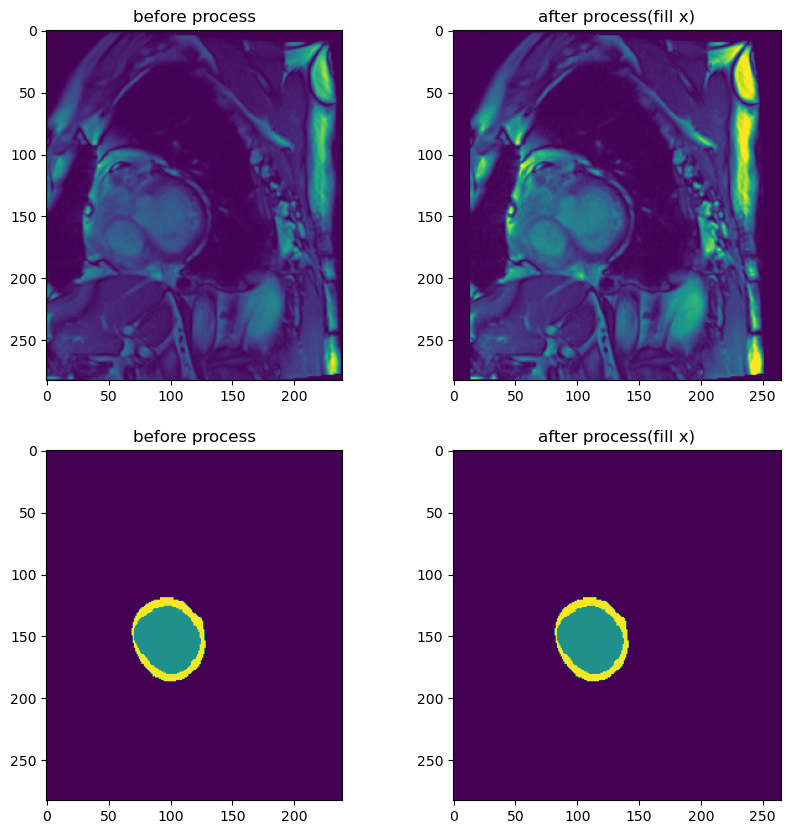

In [8]:
import torch
import matplotlib.pyplot as plt

def preprocess(itk_img, itk_lab):
    crop_size=256
    # 将SimpleITK图像转换为NumPy数组
    img = sitk.GetArrayFromImage(itk_img)
    lab = sitk.GetArrayFromImage(itk_lab)

    # 对图像进行百分位数裁剪，将值限制在0到百分位数的98%之间，以处理可能存在的异常值
    max98 = np.percentile(img, 98)
    img = np.clip(img, 0, max98)

    # 获取图像的维度
    z, y, x = img.shape

    ''' 
    img 是一个三维数组，表示图像数据，形状为 (z, y, x)，其中 z 表示深度(z 轴方向)、y 表示高度(y 轴方向)、x 表示宽度(x 轴方向）。
    (0, 0) 表示在第一个轴(z 轴方向）不进行填充。
    (0, 0) 表示在第二个轴(y 轴方向）不进行填充。
    (diff, diff) 表示在第三个轴(x 轴方向）两侧分别填充 diff 个元素。
    '''
    # 如果图像的宽度小于指定的裁剪尺寸，进行填充以满足裁剪尺寸
    if x < crop_size:
        diff = (crop_size + 10 - x) // 2
        img = np.pad(img, ((0, 0), (0, 0), (diff, diff)))
        lab = np.pad(lab, ((0, 0), (0, 0), (diff, diff)))

    # 如果图像的高度小于指定的裁剪尺寸，进行填充以满足裁剪尺寸
    if y < crop_size:
        diff = (crop_size + 10 - y) // 2
        img = np.pad(img, ((0, 0), (diff, diff), (0, 0)))
        lab = np.pad(lab, ((0, 0), (diff, diff), (0, 0)))

    # 对图像进行归一化，将像素值缩放到0到1之间
    img = img / max98

    # 将NumPy数组转换为PyTorch张量
    tensor_img = torch.from_numpy(img).float()
    tensor_lab = torch.from_numpy(lab).long()

    # 返回处理后的图像张量和标签张量
    return tensor_img, tensor_lab

fig,axes=plt.subplots(2,2,figsize=(10,10))

npimg=sitk.GetArrayFromImage(img)
nplab=sitk.GetArrayFromImage(lab)
print(npimg.shape)

axes[0,0].imshow(npimg[2,:,:])
axes[0,0].set_title('before process')

axes[1,0].imshow(nplab[2,:,:])
axes[1,0].set_title('before process')

img,lab=preprocess(img,lab)

axes[0,1].imshow(img[2,:,:])
axes[0,1].set_title("after process(fill x)")

axes[1,1].imshow(lab[2,:,:])
axes[1,1].set_title('after process(fill x)')

print(img.shape)



In [9]:
imgg=img[1]
imgg.shape

torch.Size([283, 265])

# 数据增强（随机裁剪、中心裁剪以及随机缩放和旋转）
- 这些函数在数据预处理过程中引入了随机性，从而增强了数据集的多样性，有助于提高模型的鲁棒性和性能。

In [10]:
''' 
randcrop( img, label): 随机裁剪函数
输入: img 是图像数据, label 是相应的标签数据。
H 和 W 是图像的高度和宽度。
随机生成裁剪的起始位置 rand_x 和 rand_y。
从原图像中裁剪出大小为 self.crop_size 的图像块，分别得到裁剪后的图像和标签。
'''
def randcrop(img, label):
    H, W = img.shape

    crop_size=256
    diff_H = H - crop_size
    diff_W = W - crop_size

    rand_x = np.random.randint(0, diff_H)
    rand_y = np.random.randint(0, diff_W)

    croped_img = img[rand_x:rand_x + crop_size, rand_y:rand_y + crop_size]
    croped_lab = label[rand_x:rand_x + crop_size, rand_y:rand_y + crop_size]
    
    return croped_img, croped_lab

img1,lab1= randcrop(img[2],lab[2])

In [11]:
''' 
center_crop(self, img, label): 中心裁剪函数

输入: img 是图像数据,label 是相应的标签数据。
H 和 W 是图像的高度和宽度。
计算中心裁剪的起始位置 rand_x 和 rand_y。
从原图像中裁剪出大小为 self.crop_size 的图像块，分别得到裁剪后的图像和标签。
'''
def center_crop(img, label):
    H, W = img.shape

    crop_size=256
    diff_H = H - crop_size
    diff_W = W - crop_size

    rand_x = diff_H // 2
    rand_y = diff_W // 2

    croped_img = img[rand_x:rand_x + crop_size, rand_y:rand_y + crop_size]
    croped_lab = label[rand_x:rand_x + crop_size, rand_y:rand_y + crop_size]

    return croped_img, croped_lab

img2,lab2 =center_crop(img[2],lab[2])

In [12]:
''' 
random_zoom_rotate(self, img, label): 随机缩放和旋转函数

输入: img 是图像数据,label 是相应的标签数据。
随机生成缩放因子 scale_x 和 scale_y,然后构造缩放矩阵 theta_scale。
随机生成旋转角度 angle,然后构造旋转矩阵 theta_rotate。
通过 theta_rotate 构造仿射变换的网格，然后使用 F.grid_sample 进行图像的缩放和旋转。
最终返回缩放和旋转后的图像和标签。
'''
import math
def random_zoom_rotate(img, label):
    scale,rotate = 0.3, 180
    scale_x = np.random.random() * 2 * scale + (1 - scale)
    scale_y = np.random.random() * 2 * scale + (1 - scale)

    theta_scale = torch.tensor([[scale_x, 0, 0],
                                    [0, scale_y, 0],
                                    [0, 0, 1]]).float()
    angle = (float(np.random.randint(-rotate, rotate)) / 180.) * math.pi

    theta_rotate = torch.tensor([[math.cos(angle), -math.sin(angle), 0],
                                     [math.sin(angle), math.cos(angle), 0],
                                     ]).float()

    theta_rotate = theta_rotate.unsqueeze(0)
    grid = F.affine_grid(theta_rotate, img.size())
    img = F.grid_sample(img, grid, mode='bilinear')
    label = F.grid_sample(label.float(), grid, mode='nearest').long()

    return img, label

img3,lab3=random_zoom_rotate(img.unsqueeze(0),lab.unsqueeze(0))

d:\Anacona\envs\hxd\lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
d:\Anacona\envs\hxd\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


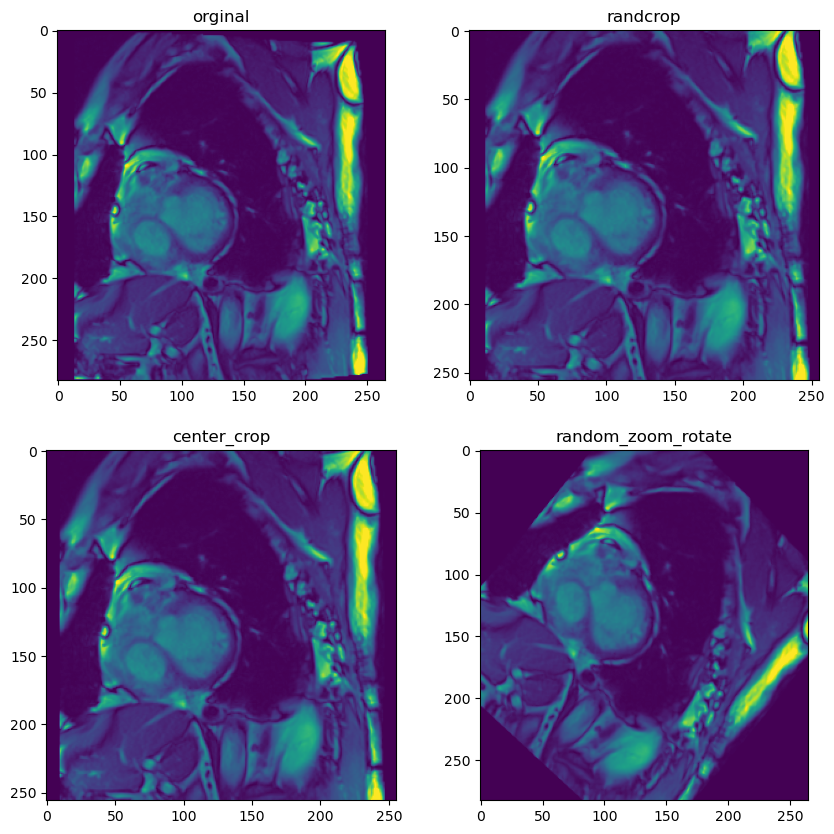

In [13]:
fig,axes=plt.subplots(2,2,figsize=(10,10))

axes[0,0].imshow(img[2])
axes[0,0].set_title("orginal")

axes[0,1].imshow(img1)
axes[0,1].set_title("randcrop")

axes[1,0].imshow(img2)
axes[1,0].set_title("center_crop")

axes[1,1].imshow(img3[0,2,:,:])
axes[1,1].set_title("random_zoom_rotate")

plt.show()

In [14]:
''' 
处理心脏磁共振图像数据的 PyTorch 数据集类 CMRDataset。
该类继承自 torch.utils.data.Dataset,并实现了 __init__、__len__ 和 __getitem__ 方法，用于加载和处理数据。

该数据集类主要完成以下功能：

1. 在初始化时,根据指定的模式(训练或测试)和域(A、B、C、D)加载数据文件。

2. 实现 __len__ 方法，返回数据集的长度。

3. 实现 __getitem__ 方法，返回指定索引处的图像和标签。

4. 定义了一些数据处理方法，如 preprocess、randcrop、center_crop 和 random_zoom_rotate,用于数据增强和预处理。

5. 还包含了一些数据处理和增强的操作，如高斯噪声、亮度调整、Gamma 校正、随机缩放和旋转等，这些操作可以增加数据的多样性，有助于提高模型的鲁棒性和泛化能力。
'''

from torch.utils.data import Dataset
import pandas as pd
import os

class CMRDataset(Dataset):
    def __init__(self, dataset_dir, mode='train', domain='A', crop_size=256, scale=0.1, rotate=10, debug=False):

        self.mode = mode
        self.dataset_dir = dataset_dir
        self.crop_size = crop_size
        self.scale = scale
        self.rotate = rotate

        if self.mode == 'train':
            pre_face = 'Training'
            if 'C' in domain or 'D' in domain:
                print('No domain C or D in Training set')
                raise BaseException

        elif self.mode == 'test':
            pre_face = 'Testing'

        else:
            print('Wrong mode')
            raise BaseException
        if debug:
            # validation set is the smallest, need the shortest time for load data.
            pre_face = 'Testing'

        path = self.dataset_dir + pre_face + '/'
        print('start loading data')

        name_list = []

        if 'A' in domain:
            df = pd.read_csv(self.dataset_dir + pre_face + '_A.csv')
            name_list += np.array(df['name']).tolist()
        if 'B' in domain:
            df = pd.read_csv(self.dataset_dir + pre_face + '_B.csv')
            name_list += np.array(df['name']).tolist()
        if 'C' in domain:
            df = pd.read_csv(self.dataset_dir + pre_face + '_C.csv')
            name_list += np.array(df['name']).tolist()
        if 'D' in domain:
            df = pd.read_csv(self.dataset_dir + pre_face + '_D.csv')
            name_list += np.array(df['name']).tolist()

        img_list = []
        lab_list = []
        spacing_list = []

        for name in name_list:
            for name_idx in os.listdir(path + name):
                if 'gt' in name_idx:
                    continue
                else:
                    idx = name_idx.split('_')[2].split('.')[0]

                    itk_img = sitk.ReadImage(path + name + '/%s_sa_%s.nii.gz' % (name, idx))
                    itk_lab = sitk.ReadImage(path + name + '/%s_sa_gt_%s.nii.gz' % (name, idx))

                    spacing = np.array(itk_lab.GetSpacing()).tolist()
                    spacing_list.append(spacing[::-1])

                    assert itk_img.GetSize() == itk_lab.GetSize()
                    img, lab = self.preprocess(itk_img, itk_lab)

                    img_list.append(img)
                    lab_list.append(lab)

        self.img_slice_list = []
        self.lab_slice_list = []
        if self.mode == 'train':
            for i in range(len(img_list)):
                tmp_img = img_list[i]
                tmp_lab = lab_list[i]

                z, x, y = tmp_img.shape

                for j in range(z):
                    self.img_slice_list.append(tmp_img[j])
                    self.lab_slice_list.append(tmp_lab[j])

        else:
            self.img_slice_list = img_list
            self.lab_slice_list = lab_list
            self.spacing_list = spacing_list

        print('load done, length of dataset:', len(self.img_slice_list))

    def __len__(self):
        return len(self.img_slice_list)

    def preprocess(self, itk_img, itk_lab):

        img = sitk.GetArrayFromImage(itk_img)
        lab = sitk.GetArrayFromImage(itk_lab)

        max98 = np.percentile(img, 98)
        img = np.clip(img, 0, max98)

        z, y, x = img.shape
        if x < self.crop_size:
            diff = (self.crop_size + 10 - x) // 2
            img = np.pad(img, ((0, 0), (0, 0), (diff, diff)))
            lab = np.pad(lab, ((0, 0), (0, 0), (diff, diff)))
        if y < self.crop_size:
            diff = (self.crop_size + 10 - y) // 2
            img = np.pad(img, ((0, 0), (diff, diff), (0, 0)))
            lab = np.pad(lab, ((0, 0), (diff, diff), (0, 0)))

        img = img / max98
        tensor_img = torch.from_numpy(img).float()
        tensor_lab = torch.from_numpy(lab).long()

        return tensor_img, tensor_lab

    def __getitem__(self, idx):
        tensor_image = self.img_slice_list[idx]
        tensor_label = self.lab_slice_list[idx]

        if self.mode == 'train':
            # unsqueeze(0).unsqueeze(0)：在第一个和第二个维度上添加一个维度，将图像和标签的形状从 [C, H, W] 扩展为 [1, 1, C, H, W]。这是为了将单个通道的图像和标签匹配到一个通道上。
            tensor_image = tensor_image.unsqueeze(0).unsqueeze(0)
            tensor_label = tensor_label.unsqueeze(0).unsqueeze(0)

            # Gaussian Noise 高斯噪声：给图像张量添加服从均值为0、标准差为0.02的高斯噪声，以增加数据的多样性。
            tensor_image += torch.randn(tensor_image.shape) * 0.02
            
            # Additive brightness 亮度调整：随机添加一个服从均值为0、标准差为0.7的正态分布随机数到图像张量，以进行亮度的随机调整。
            rnd_bn = np.random.normal(0, 0.7)  # 0.03
            tensor_image += rnd_bn
            
            # gamma Gamma 校正：对图像张量进行 Gamma 校正，以改变图像的对比度。
            minm = tensor_image.min()
            rng = tensor_image.max() - minm
            gamma = np.random.uniform(0.5, 1.6)
            tensor_image = torch.pow((tensor_image - minm) / rng, gamma) * rng + minm

            # 对图像和标签进行随机缩放和旋转操作，增加样本的多样性。
            tensor_image, tensor_label = self.random_zoom_rotate(tensor_image, tensor_label)
            
            # 对图像和标签进行随机缩放和旋转操作，增加样本的多样性。
            tensor_image, tensor_label = self.randcrop(tensor_image, tensor_label)
        else:
            # 在非训练模式下（其他模式），只执行了 center_crop 操作，将图像和标签进行中心裁剪。
            tensor_image, tensor_label = self.center_crop(tensor_image, tensor_label)

        assert tensor_image.shape == tensor_label.shape

        if self.mode == 'train':
            return tensor_image, tensor_label
        else:
            return tensor_image, tensor_label, np.array(self.spacing_list[idx])

    def randcrop(self, img, label):
        _, _, H, W = img.shape

        diff_H = H - self.crop_size
        diff_W = W - self.crop_size

        rand_x = np.random.randint(0, diff_H)
        rand_y = np.random.randint(0, diff_W)

        croped_img = img[0, :, rand_x:rand_x + self.crop_size, rand_y:rand_y + self.crop_size]
        croped_lab = label[0, :, rand_x:rand_x + self.crop_size, rand_y:rand_y + self.crop_size]

        return croped_img, croped_lab

    def center_crop(self, img, label):
        D, H, W = img.shape

        diff_H = H - self.crop_size
        diff_W = W - self.crop_size

        rand_x = diff_H // 2
        rand_y = diff_W // 2

        croped_img = img[:, rand_x:rand_x + self.crop_size, rand_y:rand_y + self.crop_size]
        croped_lab = label[:, rand_x:rand_x + self.crop_size, rand_y:rand_y + self.crop_size]

        return croped_img, croped_lab

    def random_zoom_rotate(self, img, label):
        scale_x = np.random.random() * 2 * self.scale + (1 - self.scale)
        scale_y = np.random.random() * 2 * self.scale + (1 - self.scale)

        theta_scale = torch.tensor([[scale_x, 0, 0],
                                    [0, scale_y, 0],
                                    [0, 0, 1]]).float()
        angle = (float(np.random.randint(-self.rotate, self.rotate)) / 180.) * math.pi

        theta_rotate = torch.tensor([[math.cos(angle), -math.sin(angle), 0],
                                     [math.sin(angle), math.cos(angle), 0],
                                     ]).float()

        theta_rotate = theta_rotate.unsqueeze(0)
        grid = F.affine_grid(theta_rotate, img.size())
        img = F.grid_sample(img, grid, mode='bilinear')
        label = F.grid_sample(label.float(), grid, mode='nearest').long()

        return img, label

# 深度学习中的图像分割标准dice系数
- dice系数的取值范围为0-1,越接近1说明构建的模型越好
- Dice系数是像素级别的，取值范围在0到1之间，取值越大表示越相似。真实的目标（groundtruth）出现在某片区域X，我们的模型预测结果的目标区域为Y，那么Dice系数公式为：
  $$ s=\frac{2\left | X\cap Y \right | }{X+Y} $$
  其中$\left | X\cap Y \right |$ 是X和Y之间的交集,|X|和|Y|分别表示X和Y的元素的个数，分子乘2为了保证分母重复计算后取值范围在[0,1]之间。因此dice loss可以写为：
  $$ L_{dice}=1 - \frac{2\left | X\cap Y \right | }{X+Y} $$
- 对于二分类问题，一般预测值分为以下几种:
  - TP: true positive，真阳性，预测是阳性，预测对了，实际也是正例。
  - TN: true negative，真阴性，预测是阴性，预测对了，实际也是负例。
  - FP: false positive，假阳性，预测是阳性，预测错了，实际是负例。
  - FN: false negative，假阴性，预测是阴性，预测错了，实际是正例。
  - 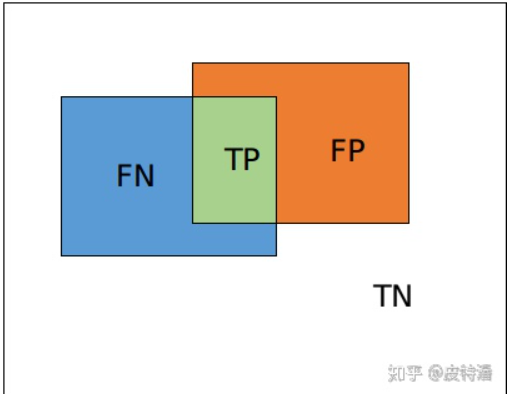
  - 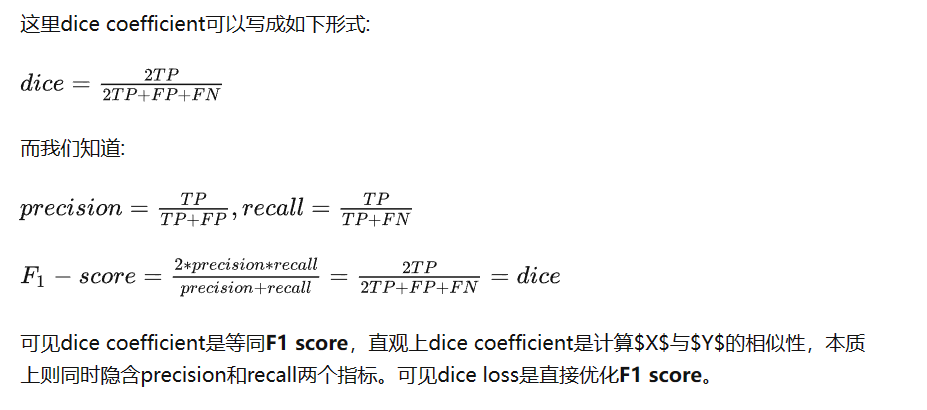
  

In [15]:
import torch.nn as nn

''' 
Dice Loss 是一种用于衡量图像分割模型预测结果的损失函数，通常用于分割任务中。
'''
class DiceLoss(nn.Module):

    def __init__(self, alpha=0.5, beta=0.5, size_average=True, reduce=True):
        super(DiceLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

        self.size_average = size_average
        self.reduce = reduce

    def forward(self, preds, targets):
        N = preds.size(0)  # 获取批次大小
        C = preds.size(1)  # 获取通道数

        P = F.softmax(preds, dim=1)  # 对预测结果进行 softmax 操作，获得概率分布
        smooth = torch.zeros(C, dtype=torch.float32).fill_(0.00001)  # 用于平滑计算的小值,避免分母为零，从而防止在计算中出现除以零的情况(平滑系数)

        class_mask = torch.zeros(preds.shape).to(preds.device)  # 创建一个与预测结果形状相同的零张量
        class_mask.scatter_(1, targets, 1.)  # 将真实标签 targets 设置为 1，其它位置为 0,第一个1表示第一维度（类别）

        ones = torch.ones(preds.shape).to(preds.device)
        P_ = ones - P
        class_mask_ = ones - class_mask

        TP = P * class_mask  # 计算 True Positive（TP）
        print("TP shape is: ",TP.shape)
        FP = P * class_mask_  # 计算 False Positive（FP）
        FN = P_ * class_mask  # 计算 False Negative（FN）

        smooth = smooth.to(preds.device)
        self.alpha = FP.transpose(0, 1).reshape(C, -1).sum(dim=(1)) / ((FP.transpose(0, 1).reshape(C, -1).sum(
            dim=(1)) + FN.transpose(0, 1).reshape(C, -1).sum(dim=(1))) + smooth)  # 计算 alpha 参数，用于平衡 TP 和 FP

        self.alpha = torch.clamp(self.alpha, min=0.2, max=0.8)  # 将 alpha 限制在一定范围内
        self.beta = 1 - self.alpha
        num = torch.sum(TP.transpose(0, 1).reshape(C, -1), dim=(1)).float()  # 计算 TP 的总和
        print("num shape is: ",num.shape)
        
        den = num + self.alpha * torch.sum(FP.transpose(0, 1).reshape(C, -1), dim=(1)).float() + self.beta * torch.sum(
            FN.transpose(0, 1).reshape(C, -1), dim=(1)).float()  # 计算分母
        print("den shape is: ",den.shape)

        dice = num / (den + smooth)  # 计算 Dice 系数

        # 若不减少维度
        if not self.reduce:
            loss = torch.ones(C).to(dice.device) - dice
            return loss

        loss = 1 - dice  # 计算 Dice Loss
        loss = loss.sum()

        # 若进行平均
        if self.size_average:
            loss /= C

        return loss
    
# 创建模拟的预测结果和真实标签
batch_size = 4
num_classes = 3
height = 256
width = 256

preds = torch.rand(batch_size, num_classes, height, width)  # 随机的预测结果
targets = torch.randint(0, num_classes, (batch_size, height, width))  # 随机的真实标签

# 创建 DiceLoss 对象
dice_loss = DiceLoss()

# 计算 Dice Loss
loss = dice_loss(preds, targets.unsqueeze(1))

print("Dice Loss:", loss.item())


TP shape is:  torch.Size([4, 3, 256, 256])
num shape is:  torch.Size([3])
den shape is:  torch.Size([3])
Dice Loss: 0.6664894223213196


# 模型训练技巧

In [16]:
# 学习率调整函数
''' 
参数：
optimizer: 优化器，用于更新模型参数的优化算法。
init_lr: 初始学习率。
epoch: 当前训练的 epoch 数。
warmup_epoch: 预热阶段的 epoch 数，预热阶段通常用于让模型更快地收敛。
max_epoch: 总的训练 epoch 数。

主要逻辑：
如果当前 epoch 在预热阶段(0 到 warmup_epoch 之间），则根据指数函数调整学习率，使学习率逐渐增加到初始学习率。
如果当前 epoch 不在预热阶段，那么使用一个衰减函数（常见的是多项式衰减），将学习率随着训练的进行逐渐减小。
在每个优化器参数组上更新学习率。

函数会根据当前的 epoch 数和预定义的参数计算新的学习率，并更新优化器的学习率。通过这种方式，可以灵活地控制学习率的变化，以优化模型的训练过程。
'''
def exp_lr_scheduler_with_warmup(optimizer, init_lr, epoch, warmup_epoch, max_epoch):
    if epoch >= 0 and epoch <= warmup_epoch:
        lr = init_lr * 2.718 ** (10 * (float(epoch) / float(warmup_epoch) - 1.))
        if epoch == warmup_epoch:
            lr = init_lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return lr

    else:
        lr = init_lr * (1 - epoch / max_epoch) ** 0.9
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    return lr